In [1]:
import albumentations as A
import cv2 as cv
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2

from modules import *
from networks import *
from training import *

COORDS = 'polar'  # cartesian, polar
ARCH = 'dual'  # dual, cascade
MODEL = 'ref'  # rau, ref, swin

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SIZE = 256 if MODEL != 'swin' else 224
transform = A.Compose([
    A.Resize(height=SIZE, width=SIZE, interpolation=cv.INTER_AREA),
    A.Lambda(image=sharpen, p=1.0),
    A.Lambda(image=polar_transform, mask=polar_transform),
    A.Normalize(),
    ToTensorV2(),
])

loader = load_dataset(
    ['../data/DRISHTI/ROI/TestImages'],
    ['../data/DRISHTI/ROI/TestMasks'],
    transform,
    batch_size=1,
    shuffle=False,
)

# Sample data
images, masks = next(iter(loader))
images = images.float().to(device)
masks = masks.long().to(device)

path = rf"..\models\{COORDS}\{MODEL}\binary.pth"
checkpoint = load_checkpoint(path, map_location=device)
base_model = checkpoint['model'].eval()

path = rf"..\models\{COORDS}\{MODEL}\{ARCH}.pth"
checkpoint = load_checkpoint(path, map_location=device)
model = checkpoint['model'].eval()

Loaded dataset with 51 samples in 51 batches.
=> Loading checkpoint: ..\models\polar\ref\binary.pth
=> Loading checkpoint: ..\models\polar\ref\dual.pth


In [2]:
res = evaluate(
    ARCH, model, loader,
    base_model=base_model if ARCH == 'cascade' else None,
    inter_process_fn=interprocess if ARCH == 'cascade' else None,
    post_process_fn=postprocess,
    inverse_transform=undo_polar_transform,
    od_thresh=0.19,
    oc_thresh=0.25,
    tta=False,
)
print(ARCH, MODEL, COORDS)
print(f'OD - Acc: {res["accuracy_OD"]:.4f}  Sen: {res["sensitivity_OD"]:.4f}  Spe: {res["specificity_OD"]:.4f}  Dice: {res["dice_OD"]:.4f}  IOU: {res["iou_OD"]:.4f}')
print(f'OC - Acc: {res["accuracy_OC"]:.4f}  Sen: {res["sensitivity_OC"]:.4f}  Spe: {res["specificity_OC"]:.4f}  Dice: {res["dice_OC"]:.4f}  IOU: {res["iou_OC"]:.4f}')

Evaluating dual segmentation: 100%|██████████| 51/51 [01:06<00:00,  1.31s/it, accuracy_OC=0.972, accuracy_OD=0.984, balance_accuracy_OC=0.953, balance_accuracy_OD=0.98, dice_OC=0.893, dice_OD=0.969, fn_OC=832, fn_OD=528, fnr_OC=0.0754, fnr_OD=0.029, fp_OC=1e+3, fp_OD=530, fpr_OC=0.0176, fpr_OD=0.011, iou_OC=0.817, iou_OD=0.941, npv_OC=0.985, npv_OD=0.989, precision_OC=0.885, precision_OD=0.969, sensitivity_OC=0.925, sensitivity_OD=0.971, specificity_OC=0.982, specificity_OD=0.989, tn_OC=5.53e+4, tn_OD=4.82e+4, tp_OC=8.43e+3, tp_OD=1.63e+4]      

dual ref polar
OD - Acc: 0.9839  Sen: 0.9710  Spe: 0.9890  Dice: 0.9693  IOU: 0.9408
OC - Acc: 0.9720  Sen: 0.9246  Spe: 0.9824  Dice: 0.8928  IOU: 0.8171


Initial shapes: torch.Size([1, 3, 256, 256]) torch.Size([1, 256, 256])
Min: tensor(-2.1179) tensor(0)
Max: tensor(1.6838) tensor(2)
TTA shapes: torch.Size([8, 3, 256, 256]) torch.Size([8, 256, 256])
Numpy shapes: (8, 256, 256, 3) (8, 256, 256)


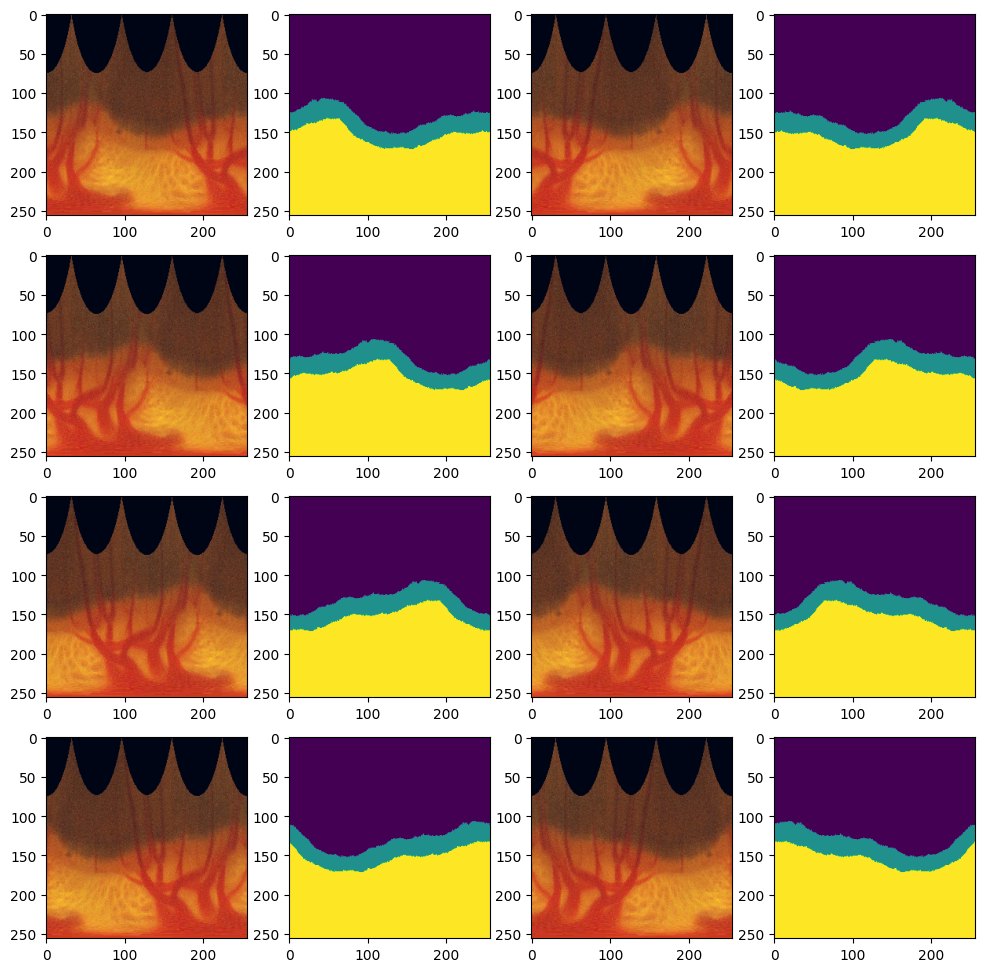

In [10]:
batch_images, batch_masks = next(iter(loader))
batch_images, batch_masks = batch_images.float(), batch_masks.long()

print('Initial shapes:', batch_images.shape, batch_masks.shape)
print('Min:', batch_images.min(), batch_masks.min())
print('Max:', batch_images.max(), batch_masks.max())
tta_images, tta_masks = d4_transform(batch_images, batch_masks, polar=True)
if tta_masks is None:
    tta_masks = torch.zeros(tta_images.shape[0], tta_images.shape[2], tta_images.shape[3], 1)
print('TTA shapes:', tta_images.shape, tta_masks.shape)

images = tta_images.detach().cpu().numpy().transpose(0, 2, 3, 1)
masks = tta_masks.detach().cpu().numpy()
images -= images.min()
images /= images.max()
print('Numpy shapes:', images.shape, masks.shape)

fig, ax = plt.subplots(4, 4, figsize=(12, 12))
ax = ax.flatten()
ax[0].imshow(images[0])
ax[1].imshow(masks[0])
ax[2].imshow(images[1])
ax[3].imshow(masks[1])
ax[4].imshow(images[2])
ax[5].imshow(masks[2])
ax[6].imshow(images[3])
ax[7].imshow(masks[3])
ax[8].imshow(images[4])
ax[9].imshow(masks[4])
ax[10].imshow(images[5])
ax[11].imshow(masks[5])
ax[12].imshow(images[6])
ax[13].imshow(masks[6])
ax[14].imshow(images[7])
ax[15].imshow(masks[7])
plt.show()

od_logits.shape = torch.Size([8, 1, 256, 256]), oc_logits.shape = torch.Size([8, 1, 256, 256])
od_probabilities.shape = torch.Size([8, 1, 256, 256]), oc_probabilities.shape = torch.Size([8, 1, 256, 256])
probabilities.shape = torch.Size([8, 2, 256, 256])
od_predictions.shape = torch.Size([8, 1, 256, 256]), oc_predictions.shape = torch.Size([8, 1, 256, 256])
predictions.shape = torch.Size([8, 256, 256])


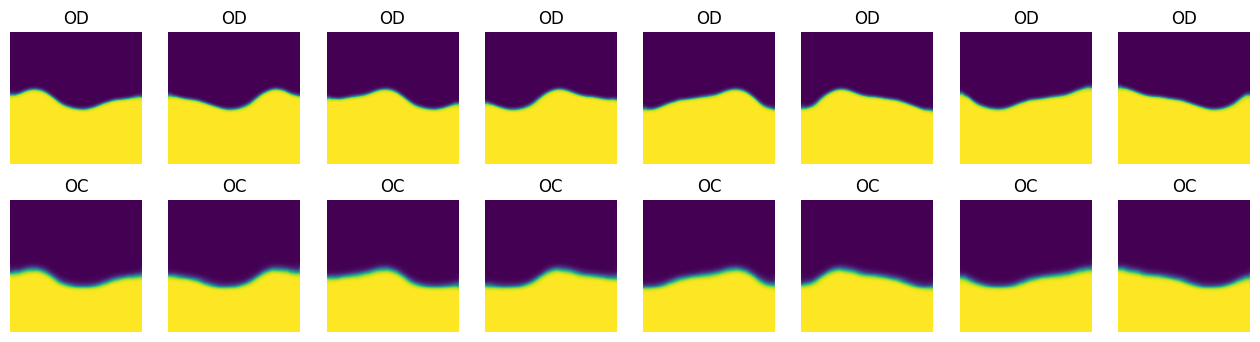

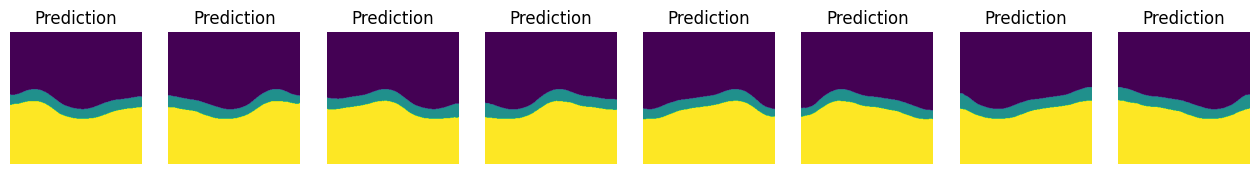

In [11]:
batch_images, batch_masks = next(iter(loader))
batch_images, batch_masks = batch_images.to(device).float(), batch_masks.to(device).long()
tta_images, tta_masks = d4_transform(batch_images, batch_masks, polar=True)

model.eval()
with torch.no_grad():
    od_logits, oc_logits = model(tta_images)
print(f'{od_logits.shape = }, {oc_logits.shape = }')
od_probabilities = torch.sigmoid(od_logits)
oc_probabilities = torch.sigmoid(oc_logits)
print(f'{od_probabilities.shape = }, {oc_probabilities.shape = }')
probabilities = torch.cat([od_probabilities, oc_probabilities], dim=1)  # (N, 2, H, W)
print(f'{probabilities.shape = }')

od_predictions = (od_probabilities > 0.5).long()  # (N, 1, H, W)
oc_predictions = (oc_probabilities > 0.5).long()  # (N, 1, H, W)
print(f'{od_predictions.shape = }, {oc_predictions.shape = }')

predictions = torch.zeros_like(oc_predictions)  # (N, 1, H, W)
predictions[od_predictions == 1] = 1
predictions[oc_predictions == 1] = 2
predictions = predictions.squeeze(1)  # (N, H, W)
print(f'{predictions.shape = }')

# Plot probabilities
_, ax = plt.subplots(2, 8, figsize=(16, 4))
ax = ax.flatten()
for i in range(8):
    ax[i].imshow(probabilities[i, 0].detach().cpu().numpy())
    ax[i].set_title('OD')
    ax[i].axis('off')
    ax[i + 8].imshow(probabilities[i, 1].detach().cpu().numpy())
    ax[i + 8].set_title('OC')
    ax[i + 8].axis('off')
plt.show()

# Plot predictions
_, ax = plt.subplots(1, 8, figsize=(16, 4))
ax = ax.flatten()
for i in range(8):
    ax[i].imshow(predictions[i].detach().cpu().numpy())
    ax[i].set_title('Prediction')
    ax[i].axis('off')
plt.show()

joined_probabilities.shape = torch.Size([1, 2, 256, 256])
joined_predictions.shape = torch.Size([1, 256, 256])


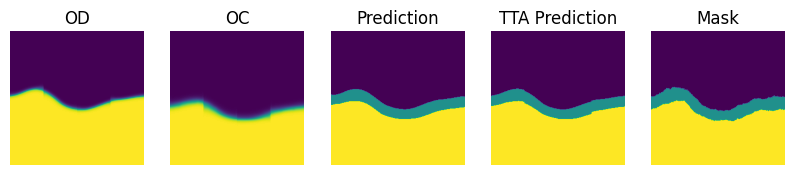

In [13]:
joined_probabilities = d4_inverse_transform(probabilities, polar=True)
print(f'{joined_probabilities.shape = }')

joined_predictions = torch.zeros_like(joined_probabilities[:, 0])
joined_predictions[joined_probabilities[:, 0] > 0.5] = 1
joined_predictions[joined_probabilities[:, 1] > 0.5] = 2
print(f'{joined_predictions.shape = }')

# Plot joined probabilities
_, ax = plt.subplots(1, 5, figsize=(10, 4))
ax = ax.flatten()
i = 0
ax[i].imshow(joined_probabilities[i, 0].detach().cpu().numpy())
ax[i].set_title('OD')
ax[i].axis('off')
ax[i + 1].imshow(joined_probabilities[i, 1].detach().cpu().numpy())
ax[i + 1].set_title('OC')
ax[i + 1].axis('off')
ax[i + 2].imshow(predictions[i].detach().cpu().numpy())
ax[i + 2].set_title('Prediction')
ax[i + 2].axis('off')
ax[i + 3].imshow(joined_predictions[i].detach().cpu().numpy())
ax[i + 3].set_title('TTA Prediction')
ax[i + 3].axis('off')
ax[i + 4].imshow(masks[0])
ax[i + 4].set_title('Mask')
ax[i + 4].axis('off')
plt.show()

predictions.shape = (8, 256, 256), joined_predictions.shape = (1, 256, 256), masks.shape = (8, 256, 256)


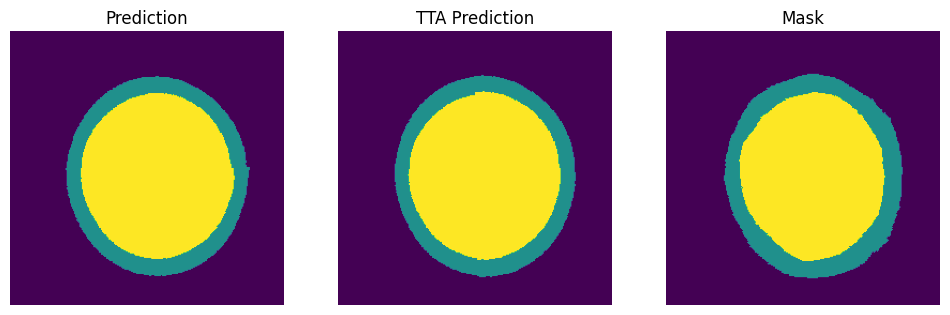

In [14]:
predictions = polar_to_cartesian(predictions)
joined_predictions = polar_to_cartesian(joined_predictions)
masks = polar_to_cartesian(masks)
print(f'{predictions.shape = }, {joined_predictions.shape = }, {masks.shape = }')

norm_pred = predictions[0]
tta_pred = joined_predictions[0]
mask = masks[0]

_, ax = plt.subplots(1, 3, figsize=(12, 4))
ax = ax.flatten()
ax[0].imshow(norm_pred)
ax[0].set_title('Prediction')
ax[0].axis('off')
ax[1].imshow(tta_pred)
ax[1].set_title('TTA Prediction')
ax[1].axis('off')
ax[2].imshow(mask)
ax[2].set_title('Mask')
ax[2].axis('off')
plt.show()

images.shape = torch.Size([2, 3, 256, 256]), masks.shape = torch.Size([2, 256, 256]), images.dtype = torch.float32, masks.dtype = torch.uint8
preds.shape = torch.Size([2, 256, 256]), probs.shape = torch.Size([2, 2, 256, 256])
dense_preds.shape = (2, 256, 256)


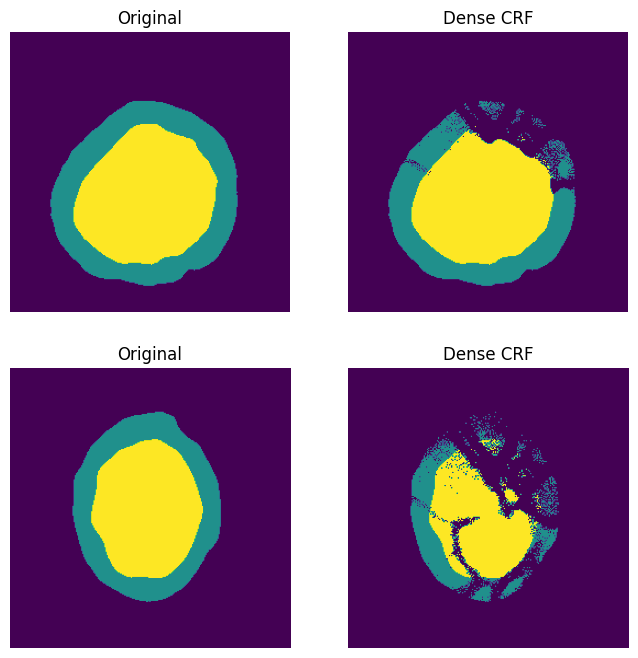

In [5]:
# Dense CRF
images, masks = next(iter(loader))

preds, probs, _ = predict('dual', model, images, masks)
print(f'{images.shape = }, {masks.shape = }, {images.dtype = }, {masks.dtype = }')
print(f'{preds.shape = }, {probs.shape = }')

# Apply dense CRF
dense_preds = dense_crf(preds, images)
print(f'{dense_preds.shape = }')

# Plot the original and processed predictions
_, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()
ax[0].imshow(preds[0])
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(dense_preds[0])
ax[1].set_title('Dense CRF')
ax[1].axis('off')
ax[2].imshow(preds[1])
ax[2].set_title('Original')
ax[2].axis('off')
ax[3].imshow(dense_preds[1])
ax[3].set_title('Dense CRF')
ax[3].axis('off')
plt.show()